In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2  # OpenCV for blurring
from PIL import Image


In [6]:
TF_MODEL_FILE_PATH = 'C:/Users/USHNISH PAL/Documents/Code/Project/Crop Disease Classification & Segmentation/Segmentation/Model/unet_100_tflite_model.tflite' 
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [7]:
segment_lite = interpreter.get_signature_runner('serving_default')
segment_lite

In [12]:
def calculate_disease_percentage(pred_mask):
    contours, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the total area from the convex hulls of the contours
    defected_area = sum([cv2.contourArea(cv2.convexHull(contour)) for contour in contours])
    total_area = pred_mask.shape[0] * pred_mask.shape[1]  # Total number of pixels in the image
    undefected_area = total_area - defected_area
    
    # Calculate the percentage of disease
    disease_percentage = (defected_area / total_area) * 100
    
    return defected_area, undefected_area, disease_percentage

In [13]:
def preprocess_image(image_path, target_size=(256, 256)):
    """Load and preprocess the image."""
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def postprocess_mask(mask_array):
    """Post-process the mask to get the segmentation result."""
    mask_array = np.squeeze(mask_array)  # Remove batch dimension
    mask_array = (mask_array > 0.5).astype(np.uint8)  # Apply threshold (0.5 for binary masks)
    return mask_array

In [14]:
def predict_and_display(image_path, model, target_size=(256, 256), save_path=None):
    """Predict the segmentation, display and save the results, and calculate the disease percentage."""
    img_array = preprocess_image(image_path, target_size)
    
    # Predict
    segmentation_lite = segment_lite(input_layer=img_array)['output_0']
    
    # Post-process
    pred_mask = postprocess_mask(segmentation_lite)
    
    # Calculate defected and undefected areas and percentage
    defected_pixels, undefected_pixels, disease_percentage = calculate_disease_percentage(pred_mask)
    
    print(f"Defected Area (pixels): {defected_pixels}")
    print(f"Undefected Area (pixels): {undefected_pixels}")
    print(f"Disease Percentage: {disease_percentage:.2f}%")
    
    # Load the original image again for overlay
    original_img = load_img(image_path, target_size=target_size)
    original_img = img_to_array(original_img) / 255.0  # Normalize
    
    # Create an overlay
    overlay = original_img.copy()
    overlay[pred_mask == 1, :] = [1, 0, 0]  # Red color for disease areas (normalized 0-1)
    
    # Apply a blur to the undiseased regions (where pred_mask == 0)
    blurred_img = cv2.GaussianBlur(original_img, (1, 1), 0)  # 21x21 kernel for blurring
    combined = np.where(np.repeat(pred_mask[:, :, np.newaxis], 3, axis=2), overlay, blurred_img)

    # Display the result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(original_img)  # Display the original image

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask and Disease Areas")
    plt.imshow(combined)  # Display the combined result
    plt.show()

    # Save the result image if save_path is provided
    if save_path:
        # Convert the combined image to uint8 format and save it
        combined_img_uint8 = (combined * 255).astype(np.uint8)
        Image.fromarray(combined_img_uint8).save(save_path)
        # print(f"Image saved at {save_path}")

Defected Area (pixels): 1088.5
Undefected Area (pixels): 64447.5
Disease Percentage: 1.66%


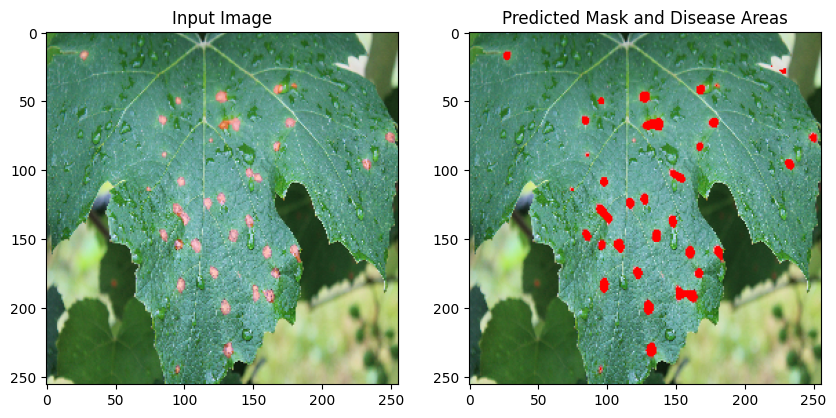

In [15]:
# Example usage
image_path = 'C:/Users/USHNISH PAL/Documents/Code/Project/Crop Disease Classification & Segmentation/Segmentation/Dataset/Test Images/Grape___Black_rot.jpg'  # Replace with your image path
save_path = 'C:/Users/USHNISH PAL/Documents/Code/Project/Crop Disease Prediction (SIH)/Coding/Segmentation/Dataset/Output/result_image.png'  # Path to save the image

predict_and_display(image_path, segment_lite, save_path=save_path)